In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

In [11]:
train_path="desktop/rps-cv-images/train"
test_path="desktop/rps-cv-images/test"
val_path="desktop/rps-cv-images/val"

In [12]:
x_train=[]
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [13]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)

In [14]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)

In [15]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [16]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [18]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 1401 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Found 350 images belonging to 3 classes.


In [19]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

In [20]:
training_set.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [21]:
train_y.shape,test_y.shape,val_y.shape

((1401,), (437,), (350,))

In [22]:
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 13s 0us/step


In [23]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [24]:
x = Flatten()(vgg.output)

In [25]:
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

In [26]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [29]:
# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
44/44 [==============================] - 524s 12s/step - loss: 0.4375 - accuracy: 0.8394 - val_loss: 0.0694 - val_accuracy: 0.9829
Epoch 2/10
44/44 [==============================] - 472s 11s/step - loss: 0.0414 - accuracy: 0.9929 - val_loss: 0.0400 - val_accuracy: 0.9914
Epoch 3/10
44/44 [==============================] - 474s 11s/step - loss: 0.0226 - accuracy: 0.9993 - val_loss: 0.0328 - val_accuracy: 0.9943
Epoch 4/10
44/44 [==============================] - 474s 11s/step - loss: 0.0147 - accuracy: 0.9993 - val_loss: 0.0335 - val_accuracy: 0.9943
Epoch 5/10
44/44 [==============================] - 493s 11s/step - loss: 0.0112 - accuracy: 0.9993 - val_loss: 0.0250 - val_accuracy: 0.9971
Epoch 6/10
44/44 [==============================] - 532s 12s/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.0248 - val_accuracy: 0.9971
Epoch 7/10
44/44 [==============================] - 564s 13s/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0232 - val_accuracy: 0.9971
Epoch 

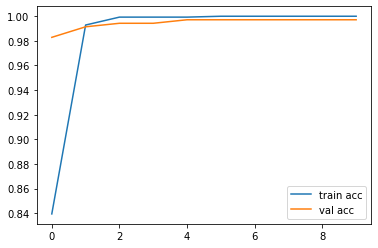

In [30]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.savefig('vgg-acc-rps-1.png')
plt.show()

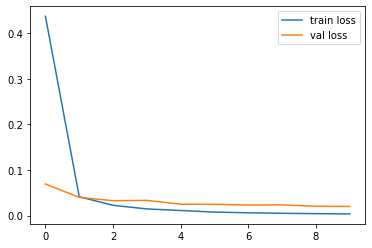

In [31]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

In [32]:
model.evaluate(test_x,test_y,batch_size=32)

14/14 [==============================] - 117s 8s/step - loss: 0.0162 - accuracy: 1.0000


[0.016199098899960518, 1.0]

In [33]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

14/14 [==============================] - 114s 8s/step


In [34]:
accuracy_score(y_pred,test_y)

1.0

In [35]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00       145
           2       1.00      1.00      1.00       150

    accuracy                           1.00       437
   macro avg       1.00      1.00      1.00       437
weighted avg       1.00      1.00      1.00       437



In [36]:
confusion_matrix(y_pred,test_y)

array([[142,   0,   0],
       [  0, 145,   0],
       [  0,   0, 150]], dtype=int64)

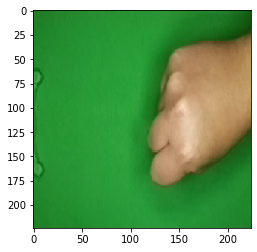

1/1 [==============================] - 0s 336ms/step
Rock


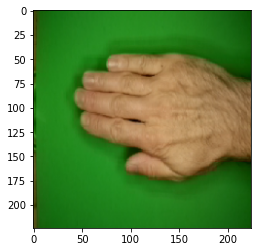

1/1 [==============================] - 0s 284ms/step
Paper


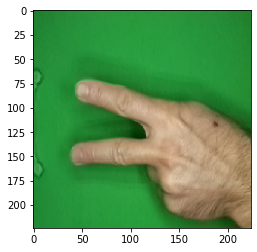

1/1 [==============================] - 0s 307ms/step
Scissors


In [41]:
path="desktop/rps-cv-images/testing"
for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    if pred[0][0]>0.5:
        print("Paper")
    elif pred[0][1]>0.5:
        print("Rock")
    elif pred[0][2]>0.5:
        print("Scissors")
    else:
        print("Unknown")